In [1]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import PIL
import pathlib

2022-08-24 11:44:31.488983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amadon/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-24 11:44:31.489052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/amadon/.kaggle’: File exists


In [4]:
! cp ~/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download gpiosenka/butterfly-images40-species/download?datasetVersionNumber=11

butterfly-images40-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
with zipfile.ZipFile('butterfly-images40-species.zip', 'r') as zip_ref:
    zip_ref.extractall('data_dir')

In [8]:
batch_size = 32
img_height = 150
img_width = 150
input_shape = (img_width, img_height, 3)

train_dir = pathlib.Path('data_dir/train/')
test_dir = pathlib.Path('data_dir/test/')
val_dir = pathlib.Path('data_dir/valid/')

In [9]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
val_image_count = len(list(val_dir.glob('*/*.jpg')))

category = []
for folder in os.listdir(train_dir):
    category.append(folder)
    
num_classes = len(category)

print("Found ", num_classes, " classes.")
print("Found ", train_image_count, " train images.")
print("Found ", test_image_count, " test images.")
print("Found ", val_image_count, " validation images")

Found  75  classes.
Found  9285  train images.
Found  375  test images.
Found  375  validation images


[]

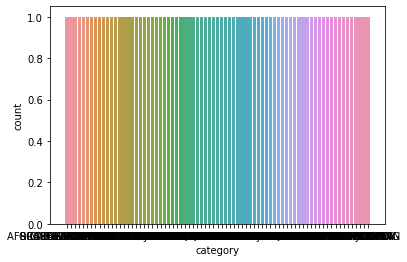

In [10]:
df = pd.DataFrame()
df['count'] = train_image_count
df['category'] = category

sns.countplot(x = df["category"])
plt.plot()

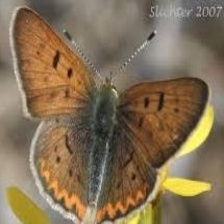

In [11]:
PURPLISH_COPPER = list(train_dir.glob(r'PURPLISH COPPER/*'))
PIL.Image.open(str(PURPLISH_COPPER[0]))

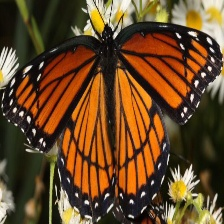

In [12]:
VICEROY= list(train_dir.glob(r'VICEROY/*'))
PIL.Image.open(str(VICEROY[5]))

In [13]:
train_generator = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9285 files belonging to 75 classes.


2022-08-24 11:45:07.443174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amadon/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-24 11:45:07.443545: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-24 11:45:07.444146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amadon-virtual-machine): /proc/driver/nvidia/version does not exist
2022-08-24 11:45:07.445709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
test_generator = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375 files belonging to 75 classes.


In [15]:
val_generator = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375 files belonging to 75 classes.


In [16]:
class_names = train_generator.class_names
print(class_names)

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPER', 'QUESTION MARK', 'RED ADMIRA

In [17]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().prefetch(buffer_size=AUTOTUNE)
test_generator = test_generator.cache().prefetch(buffer_size=AUTOTUNE)
val_generator = val_generator.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=input_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs=10

base_cnn_history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

Epoch 1/10
291/291 [==============================] - 86s 293ms/step - loss: 3.3341 - accuracy: 0.1903 - val_loss: 2.3440 - val_accuracy: 0.4027
Epoch 2/10
291/291 [==============================] - 76s 261ms/step - loss: 1.7857 - accuracy: 0.5221 - val_loss: 1.8756 - val_accuracy: 0.5040
Epoch 3/10
291/291 [==============================] - 72s 248ms/step - loss: 1.0730 - accuracy: 0.7049 - val_loss: 1.6887 - val_accuracy: 0.5627
Epoch 4/10
291/291 [==============================] - 68s 235ms/step - loss: 0.6211 - accuracy: 0.8247 - val_loss: 1.7263 - val_accuracy: 0.5813
Epoch 5/10
291/291 [==============================] - 74s 254ms/step - loss: 0.3924 - accuracy: 0.8868 - val_loss: 2.0521 - val_accuracy: 0.6000
Epoch 6/10
291/291 [==============================] - 78s 268ms/step - loss: 0.2449 - accuracy: 0.9289 - val_loss: 2.1020 - val_accuracy: 0.6187
Epoch 7/10
291/291 [==============================] - 70s 240ms/step - loss: 0.1384 - accuracy: 0.9618 - val_loss: 2.2440 - val_ac

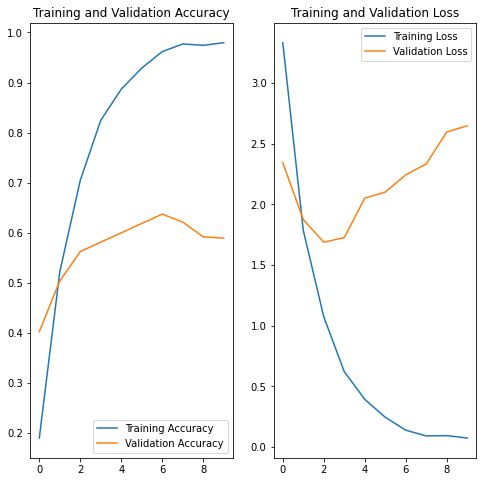

In [23]:
acc = base_cnn_history.history['accuracy']
val_acc = base_cnn_history.history['val_accuracy']

loss = base_cnn_history.history['loss']
val_loss = base_cnn_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
12/12 [==============================] - 1s 61ms/step - loss: 2.9003 - accuracy: 0.5973
Test Accuracy: 59.73333120346069


1/1 [==============================] - 0s 103ms/step
This image most likely belongs to ADONIS with a 100.00 percent confidence.


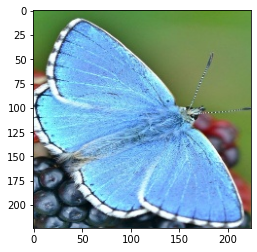

In [25]:
addonis_path = r'data_dir/6 images/4.jpg'

img = tf.keras.utils.load_img(
    addonis_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

butterfly=tf.keras.utils.load_img(addonis_path)
plt.imshow(butterfly)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [26]:
model.save('base_cnn_model.h5')

In [27]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

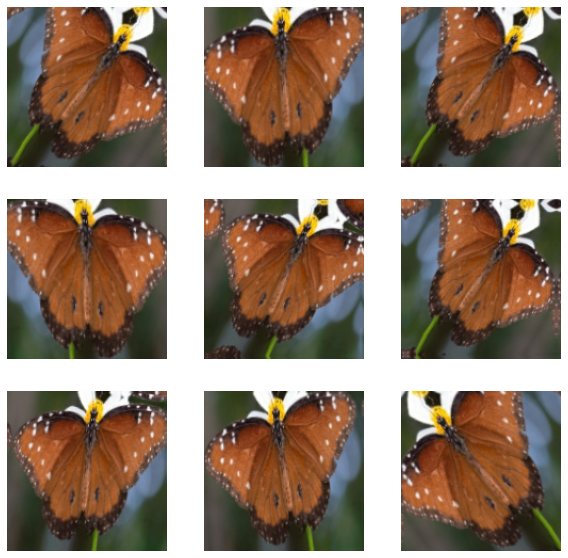

In [28]:
for image, _ in train_generator.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [29]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
aug_cnn_history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

Epoch 1/10
291/291 [==============================] - 81s 274ms/step - loss: 3.5804 - accuracy: 0.1307 - val_loss: 2.8441 - val_accuracy: 0.2560
Epoch 2/10
291/291 [==============================] - 79s 270ms/step - loss: 2.3730 - accuracy: 0.3714 - val_loss: 2.2483 - val_accuracy: 0.3893
Epoch 3/10
291/291 [==============================] - 77s 266ms/step - loss: 1.7983 - accuracy: 0.5062 - val_loss: 2.0901 - val_accuracy: 0.4533
Epoch 4/10
291/291 [==============================] - 79s 271ms/step - loss: 1.4953 - accuracy: 0.5760 - val_loss: 1.7074 - val_accuracy: 0.5333
Epoch 5/10
291/291 [==============================] - 78s 268ms/step - loss: 1.3157 - accuracy: 0.6207 - val_loss: 1.7013 - val_accuracy: 0.5680
Epoch 6/10
291/291 [==============================] - 85s 292ms/step - loss: 1.1931 - accuracy: 0.6541 - val_loss: 1.7885 - val_accuracy: 0.5413
Epoch 7/10
291/291 [==============================] - 81s 278ms/step - loss: 1.1034 - accuracy: 0.6767 - val_loss: 2.0905 - val_ac

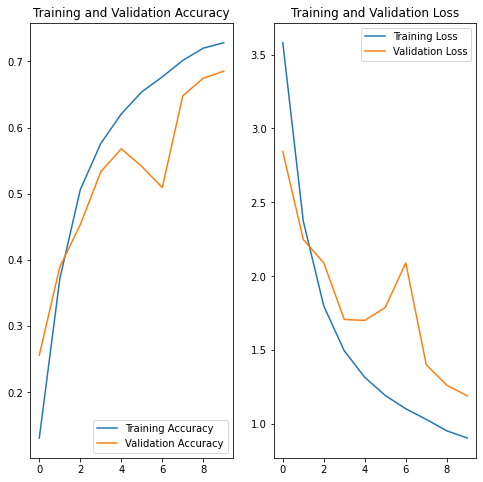

In [33]:
acc = aug_cnn_history.history['accuracy']
val_acc = aug_cnn_history.history['val_accuracy']

loss = aug_cnn_history.history['loss']
val_loss = aug_cnn_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
12/12 [==============================] - 1s 56ms/step - loss: 1.0042 - accuracy: 0.7467
Test Accuracy: 74.6666669845581


1/1 [==============================] - 0s 86ms/step
This image most likely belongs to ADONIS with a 99.90 percent confidence.


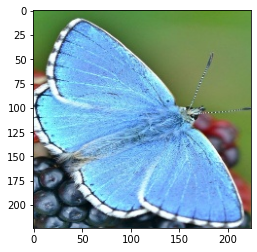

In [35]:
addonis_path = r'data_dir/6 images/4.jpg'

img = tf.keras.utils.load_img(
    addonis_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

butterfly=tf.keras.utils.load_img(addonis_path)
plt.imshow(butterfly)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)